## Creating graph from osmnx

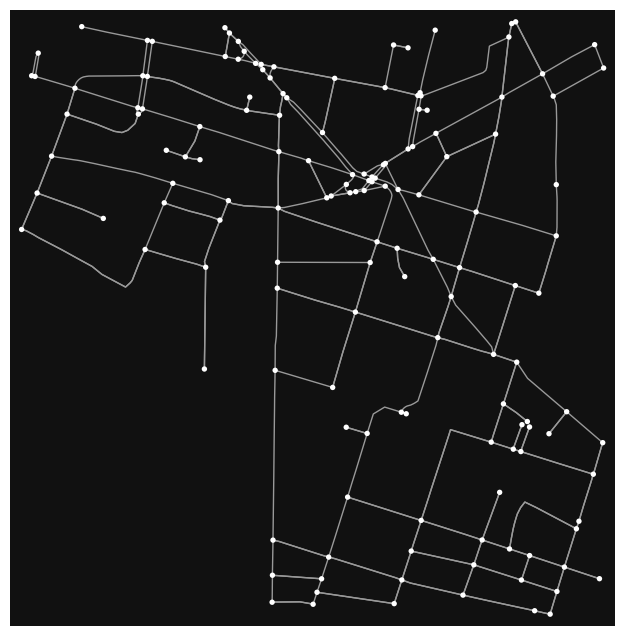

In [2]:
import osmnx as ox
from algo.graph import Graph
import matplotlib.pyplot as plt
from algo.distance import distance
G = ox.graph_from_point((21.02528315, 105.84213800949607), dist=700, network_type="drive")
ox.plot_graph(G)
plt.show()

In [3]:
list(G.edges.data())[1]

(81794043,
 98044691,
 {'osmid': 1217914500,
  'oneway': True,
  'lanes': '2',
  'name': 'Phố Hàng Bông',
  'highway': 'residential',
  'reversed': False,
  'length': 109.402,
  'geometry': <LINESTRING (105.847 21.03, 105.847 21.03, 105.847 21.03)>})

## Add more edges and vertices to the graph

In [4]:
g = Graph()
# Adding vertices
for u, v, geometry in list(G.edges.data("geometry")):
    if geometry:
        for i in range(len(geometry.coords) - 1):
            x1, y1 = geometry.coords[i]
            id_1 = g.get_id(x1, y1)
            x2, y2 = geometry.coords[i + 1]
            id_2 = g.get_id(x2, y2)
            g.addEdge(id_1, id_2, distance(y1, x1, y2, x2))
    else:
        x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
        id_1 = g.get_id(x1, y1)
        x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
        id_2 = g.get_id(x2, y2)
        g.addEdge(id_1, id_2, distance(y1, x1, y2, x2))

In [5]:
len(g.graph), sum(len(v) for v in g.graph.values())

(603, 1009)

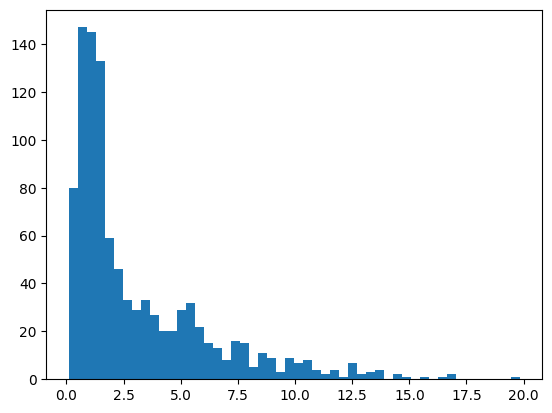

In [6]:
w = [[k[1] for k in i] for i in g.graph.values()]
w = [j for i in w for j in i]
plt.hist(w, bins=50)
plt.show()

In [7]:
threshold = 3
density = 20
count = 0
for u in g.graph.copy():
    for v, w in g.graph[u].copy():
        if w < threshold or g.check[(u, v)] or g.check[(v, u)]:
            continue
        x1, y1 = g.coords[u]
        x2, y2 = g.coords[v]
        delta_x = (x2 - x1) / (density + 1)
        delta_y = (y2 - y1) / (density + 1)
        dist = distance(y1, x1, y2, x2) / (density + 1)
        if u in [vt for vt, _ in g.graph[v]]:
            g.check[(v, u)] = True
            g.check[(u, v)] = True
        g.graph[u].remove((v, w))
        start_id = u
        end_id = v
        if g.check[(v, u)] == False:
            for _ in range(density):
                x1 += delta_x
                y1 += delta_y
                id = g.get_id(x1, y1)
                g.addEdge(start_id, id, dist)
                start_id = id
            g.addEdge(start_id, end_id, dist)
        else:
            g.graph[v].remove((u, w))
            for _ in range(density):
                x1 += delta_x
                y1 += delta_y
                id = g.get_id(x1, y1)
                g.addEdge(start_id, id, dist)
                g.addEdge(id, start_id, dist)
                start_id = id
            g.addEdge(start_id, end_id, dist)
            g.addEdge(end_id, start_id, dist)

In [9]:
len(g.graph), sum(len(v) for v in g.graph.values())

(5185, 8129)

## Save the graph to a file

In [8]:
import pickle

with open("graph.pkl", "wb") as f:
    pickle.dump(g, f)
